In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# matplotlib 한글 꺠짐 방지
# apt-get update
# apt-get install fonts-nanum* 
# apt-get install fontconfig
# fc-cache -fv  # font 캐시 날리기
# rm -rf /home/hy1/.cache/matplotlib/  #matplotliob 폰트 캐시 날리기


In [3]:
#!pip install matplotlib
#!pip install pandas

In [2]:
from datetime import date, datetime
from pyspark.sql.types import *
from pyspark.sql.functions import *
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt #그래프 패키지 모듈 등록
%matplotlib inline 


In [3]:
def cal_std_day(befor_day):   
    x = dt.datetime.now() - dt.timedelta(befor_day)
    year = x.year
    month = x.month if x.month >= 10 else '0'+ str(x.month)
    day = x.day if x.day >= 10 else '0'+ str(x.day)  
    return str(year)+ '-' +str(month)+ '-' +str(day)

In [4]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    rc('font', family='NanumGothic')

## Transform

### 1. 지역별 단위면적(km)당 인구수와 코로나 확진자 수의 상관관계를 구해보자

In [5]:
# 면적, 인구정보
area = spark.read.csv('/corona_data/loc/sido_area.csv', encoding='CP949', header=True)
popu = spark.read.csv('/corona_data/loc/sido_population.csv', encoding='CP949', header=True)

area.show(3)
popu.show(3)

+----+----+-----+
| loc|area|ratio|
+----+----+-----+
|서울|605 |  0.6|
|부산|770 |  0.8|
|대구|883 |  0.9|
+----+----+-----+
only showing top 3 rows



+----+---------+---------+---------+
| loc|    total|     male|   female|
+----+---------+---------+---------+
|전국|52739009 |26360035 |26378974 |
|서울| 9736027 | 4721977 | 5014050 |
|부산| 3396109 | 1663619 | 1732490 |
+----+---------+---------+---------+
only showing top 3 rows



In [6]:
area_popu = area.join(popu, on='loc')
#area_popu.show()
area_popu = area_popu.select(area_popu.loc, ceil((area_popu.total/area_popu.area)).alias('popu_density'))
area_popu.show()


+----+------------+
| loc|popu_density|
+----+------------+
|서울|       16093|
|부산|        4411|
|대구|        2733|
|인천|        2831|
|광주|        2920|
|대전|        2722|
|울산|        1072|
|세종|         811|
|경기|        1366|
|강원|          93|
|충북|         221|
|충남|         265|
|전북|         226|
|전남|         152|
|경북|         141|
|경남|         321|
|제주|         378|
+----+------------+



In [7]:
# 코로나 감염자 데이터 가져오기
file_name = '/corona_data/patient/corona_patient_' + cal_std_day(2) + '.json'
tmp = spark.read.json(file_name, encoding='UTF-8')
tmp.show(3)

+--------------------+---------+------+----------+--------------+----------+
|               items|numOfRows|pageNo|resultCode|     resultMsg|totalCount|
+--------------------+---------+------+----------+--------------+----------+
|[{1465, 1461477, ...|      500|     1|        00|NORMAL SERVICE|     19684|
+--------------------+---------+------+----------+--------------+----------+



In [8]:
# 지역명과, 10만명 당 감염 현황
tmp2 = tmp.select('items').first()
co_patient = spark.createDataFrame(tmp2['items'])
#co_patient.show(3)

# tmp3 = co_patient.select(co_patient.gubun.alias('loc'), co_patient.qurRate)
# tmp3.show(3)
# co_rate = area_popu.join(tmp3, on='loc').distinct().orderBy(col('loc'))
# co_rate.show()



In [9]:
pd_co = co_rate.toPandas()
pd_co['qurRate'] = pd_co['qurRate'].astype(int)
pd_co.plot(kind='scatter'
           ,x='popu_density'
           ,y='qurRate'
           ,ylim=(30000,50000)
           ,figsize=(6, 6)
          )


NameError: name 'co_rate' is not defined

### 2.  4차 예방접종 완료자와 코로나 확진자 수의 상관관계를 구해보자

In [9]:
file_name = '/corona_data/vaccine/corona_vaccine_' + cal_std_day(1) + '.json'
vaccine = spark.read.json(file_name)
#vaccine.show(3)
vaccine_df = spark.createDataFrame(vaccine.select('data').first()['data'])
#vaccine_df.show()

pop_vaccine = vaccine_df.join(popu, on='loc').select('loc', col('v4'), col('total'),
                                                     ceil(
                                                         (col('v4')/col('total')) * 100
                                                     ).alias('v_rate'))
#pop_vaccine.show(100)
tmp3 = co_patient.select(co_patient.gubun.alias('loc'), co_patient.qurRate)
co_vaccine_df = pop_vaccine.join(tmp3, on='loc')
co_vaccine_df = co_vaccine_df.select('loc', 'v_rate', 'qurRate').distinct()
co_vaccine_df.show(3)


+----+------+-------+
| loc|v_rate|qurRate|
+----+------+-------+
|강원|    18|  45979|
|경기|    13|  47883|
|경남|    15|  44098|
+----+------+-------+
only showing top 3 rows



<AxesSubplot:xlabel='v_rate', ylabel='qurRate'>

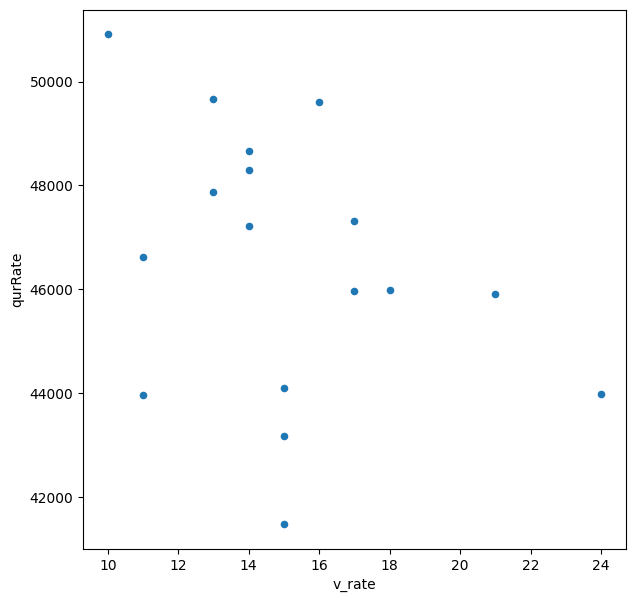

In [10]:
pd_vac = co_vaccine_df.toPandas()

pd_vac['qurRate'] = pd_vac['qurRate'].astype(int)
pd_vac.plot(kind='scatter'
           ,x='v_rate'
           ,y='qurRate'
           ,figsize=(7, 7)
          )

### 3. 다중이용시설과 코로나 확진자 수의 상관관계

In [9]:
facility = spark.read.csv('/corona_data/loc/전국다중이용시설.csv', encoding='CP949', header=True)
facility.show(3)


+----+----+------+----------------+--------------+--------+
|연도|광역|시군구|          시설명|사업자등록번호|  시설군|
+----+----+------+----------------+--------------+--------+
|2020|강원|강릉시|(주)경포솔향온천|  127-86-57613|  목욕장|
|2020|강원|강릉시|  24시황실사우나|  226-33-03247|  목욕장|
|2020|강원|강릉시|    강릉고려병원|  226-82-03662|의료기관|
+----+----+------+----------------+--------------+--------+
only showing top 3 rows



In [10]:
fac_cnt = facility.groupBy(facility.광역.alias('loc')).agg(count('*').alias('fac_cnt'))
tmp = popu.join(fac_cnt, on='loc')
fac_popu = tmp.select('loc', ceil(tmp.fac_cnt/tmp.total*100000).alias('fac_popu'))

tmp3 = co_patient.select(co_patient.gubun.alias('loc'), co_patient.qurRate)
fac_rate = fac_popu.join(tmp3, on='loc').distinct()
fac_rate.show()

+----+--------+-------+
| loc|fac_popu|qurRate|
+----+--------+-------+
|강원|      38|  45979|
|경기|      46|  47883|
|경남|      41|  44098|
|경북|      36|  41475|
|광주|      51|  49604|
|대구|      43|  43971|
|대전|      53|  48307|
|부산|      44|  43180|
|서울|      54|  49673|
|세종|      65|  50913|
|울산|      38|  46618|
|인천|      46|  47227|
|전남|      45|  43984|
|전북|      42|  45901|
|제주|      45|  48672|
|충남|      38|  45963|
|충북|      38|  47313|
+----+--------+-------+



<AxesSubplot:xlabel='fac_popu', ylabel='qurRate'>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


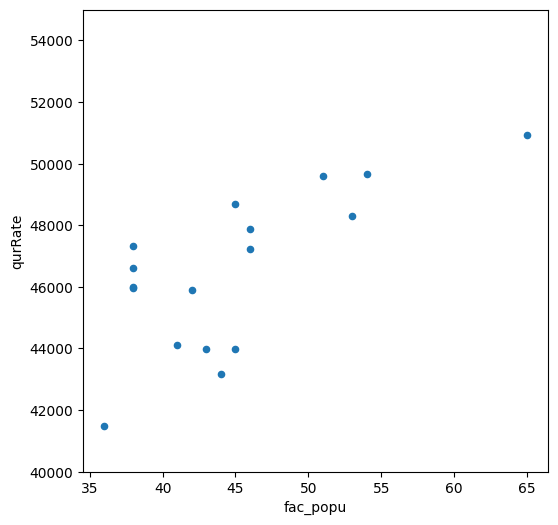

In [12]:
pd_fac = fac_rate.toPandas()

pd_fac['qurRate'] = pd_fac['qurRate'].astype(int)
pd_fac.plot(kind='scatter'
           ,x='fac_popu'
           ,y='qurRate'
           ,ylim=(40000,55000)
           ,figsize=(6, 6) 
          )

### 4. 요일별 코로나 확진자 수를 구해보자

In [10]:
file_name = '/corona_data/patient/'
tmp = spark.read.json(file_name, encoding='UTF-8')


In [27]:
data = []
for r1 in tmp.select(tmp.items).toLocalIterator():
    if not r1.items:
        continue
    for r2 in r1.items:
        data.append(r2)

patient_data = spark.createDataFrame(data)
p = patient_data.withColumn('day_of_week', dayofweek(col('stdDay')))

# localOccCnt : 당일 발생한 코로나확진자 수 - 해외유입수
# 요일별 발생한 환자 수의 합을 구한 뒤 요일로 오름차순 정렬하시오
p = p.groupBy(p.day_of_week).agg(sum(col('localOccCnt')).alias('patients')).sort(col('day_of_week'))
p.show()



+-----------+---------+
|day_of_week| patients|
+-----------+---------+
|          1|1839096.0|
|          2|1344660.0|
|          3|2728572.0|
|          4|3448596.0|
|          5|3559088.0|
|          6|2892264.0|
|          7|2320960.0|
+-----------+---------+



+-----------+---------+
|day_of_week| patients|
+-----------+---------+
|          1|1839096.0|
|          2|1344660.0|
|          3|2728572.0|
+-----------+---------+
only showing top 3 rows



<AxesSubplot:>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


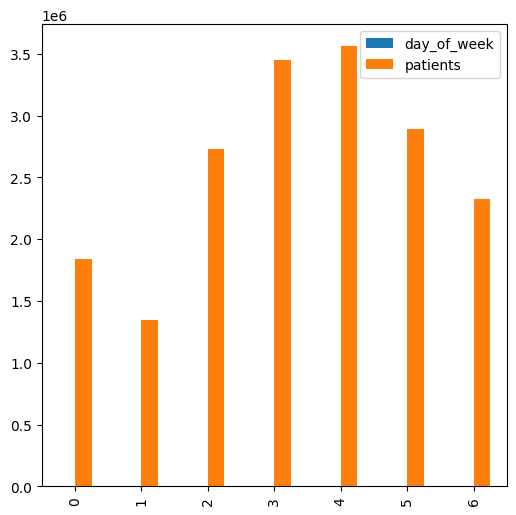

In [28]:
pd_week = p.toPandas()
pd_week.plot(kind='bar', figsize=(6, 6))